<a href="https://colab.research.google.com/github/erjank/563-a1/blob/main/feb24/mc-lj-improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy
import time
import matplotlib.pyplot as plt

def pbc(d,L):
  for i,x in enumerate(d):
    if x > L/2:
      d[i] = x-L
    elif x <= -L/2:
      d[i] = x+L
  return d

def pbc1(d,L):
  if d > L/2:
    d -= L
  elif d <= -L/2:
    d += L
  return d


def distance(ri,rj,L):
  d = pbc(rj-ri,L)
  return numpy.linalg.norm(d)

def lj(r,epsilon=1.,sigma=1.):
  return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

vlj = numpy.vectorize(lj)
vpbc = numpy.vectorize(pbc1)


def autocorr1D(array):
  ft = numpy.fft.rfft(array - numpy.average(array))
  acorr = numpy.fft.irfft(ft * numpy.conjugate(ft)) / (len(array) * numpy.var(array))
  dt = numpy.where(acorr<0)[0][0]
  nsamples = len(array)//dt
  acorr = acorr[dt:nsamples]
  return nsamples, dt

class simulation():
  def __init__(self,N=100,density= 0.5,T=1.,maxD=0.1,maxSteps=10,debug=False,seed=2):
    self.start = time.perf_counter()
    numpy.random.seed(seed)
    self.N = N
    self.L = (N/density)**(1/3)
    self.T = T
    self.maxD = maxD
    self.accept = 0
    self.reject = 0
    self.rcut = 2.5
    self.pos = numpy.zeros((N,3))
    self.debug = debug
    self.maxSteps = maxSteps
    self.energies = numpy.zeros(maxSteps)
    for i in range(self.N):
      while True:
        self.pos[i] = numpy.random.uniform(low=-self.L/2,high=self.L/2,size=3)
        if self.energy(i,initializing=True)<=0.:
          break
    self.E = self.energy()
    for i in range(self.maxSteps):
      self.trial()
      self.energies[i] = self.E
      if self.debug:
        print("{:03}:   {:.2f}".format(i, self.E))
      if i % 1000 ==0:
        if self.done():
          break
    self.stop = time.perf_counter()
    self.time = self.stop-self.start
    print("{:.2f} steps/second/particle".format(i/self.time/self.N))

  def energy(self,i=None,initializing=False):
    E = 0
    if i is not None and initializing:
      pi = self.pos[i]
      for j in range(i):
        r = distance(pi,self.pos[j],self.L)
        if r <= self.rcut:
          E += lj(r)
      return E
    if i is None:
      for i in range(self.N-1):
        pi = self.pos[i]
        for j in range(i+1,self.N):
          r = distance(pi,self.pos[j],self.L) # speed up with numpy?
          if r <= self.rcut:
            E += lj(r)
      return E

  def done(self,min_samples = 20):
    t = self.accept+self.reject
    print("t={}: E/N={:02f}".format(t-1,self.E/self.N))
    if t < 5000:
      return False
    bestSamples = 1
    for start in range(0,t//2,250):
      ns,dt = autocorr1D(self.energies[start:t])
      if ns>bestSamples:
          bestSamples = ns
      if ns >= min_samples:
        self.samples = self.energies[start:t:dt]/self.N
        print("Have {} samples, start: {}, max_t: {}".format(ns,start,t))
        print("<E>= {:02f} +/- {:02f}".format(self.samples.mean(), self.samples.std()))
        return True
    print("bestSamples={} ".format(bestSamples))
    return False

  def fastE(self):
    E = 0
    for i,p in enumerate(self.pos[:-1]):
      a = self.pos[i+1:]-p
      a = vpbc(a,self.L)
      distances = numpy.linalg.norm(a,axis=1)
      distances = distances[distances<=self.rcut]
      if len(distances)>0:
        E += vlj(distances).sum()
    return E

  def trial(self):
    i = numpy.random.randint(self.N)
    oldP = numpy.copy(self.pos[i])
    oldE = self.E
    #oldEi = self.energy()
    oldEi = self.fastE()
    d = numpy.random.uniform(low=-self.maxD,high=self.maxD,size=3)
    newP = pbc(oldP+d,self.L)
    self.pos[i] = newP
    #newEi = self.energy()
    newEi = self.fastE()
    dE = newEi - oldEi
    if numpy.random.uniform() <= numpy.exp(-dE/self.T):
      if self.debug:
        print("accept")
      self.accept += 1
      self.E += dE
      return
    else:
      if self.debug:
        print("reject")
      self.pos[i] = oldP
      self.reject += 1
      self.E = oldE
      return

t=0: E/N=-2.462357
t=1000: E/N=-2.811418
t=2000: E/N=-2.809713
t=3000: E/N=-2.747952
t=4000: E/N=-2.583709
t=5000: E/N=-2.506772
Have 29 samples, start: 0, max_t: 5001
<E>= -2.745978 +/- 0.161304
6.42 steps/second/particle


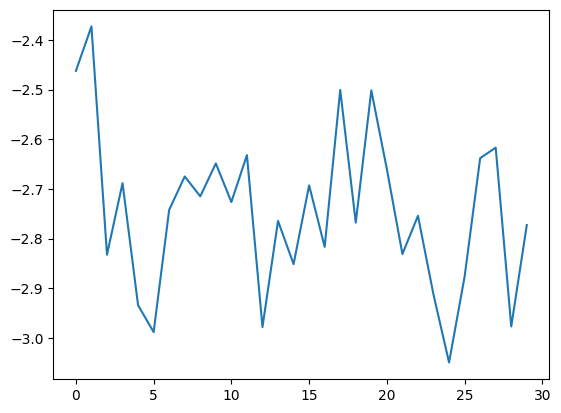

In [6]:
#fast
s = simulation(N=32, density= 0.7, T=2.0, maxSteps = 50000,debug=False,seed=23)
plt.plot(s.samples)
plt.show()

In [10]:
#loop over statepoints to get sufficient sampling
results = {}
for N in [20,25,30,50,100]:
  for density in [0.5,0.7]:
    for T in [2.0,0.5]:
      s = simulation(N=N, density= density, T=T, maxSteps = 500000,debug=False)
      results[(N,density,T)] = (s.samples,s.time)
      print("****** (N={}, density={}, T={}):".format(N,density,T), "{:02f} +/- {:02f}".format(s.samples.mean(), s.samples.std()), "steps/sec:", s.time)


t=0: E/N=-2.249443
t=1000: E/N=-2.668554
t=2000: E/N=-2.479603
t=3000: E/N=-2.731122
t=4000: E/N=-2.995024
t=5000: E/N=-2.708551
Have 35 samples, start: 0, max_t: 5001
<E>= -2.675073 +/- 0.235618
13.74 steps/second/particle
****** (N=20, density=0.5, T=2.0): -2.675073 +/- 0.235618 steps/sec: 18.200363125999502
t=0: E/N=-2.249443
t=1000: E/N=-3.249946
t=2000: E/N=-3.169638
t=3000: E/N=-3.368650
t=4000: E/N=-3.300023
t=5000: E/N=-3.224706
bestSamples=14 
t=6000: E/N=-3.367846
bestSamples=18 
t=7000: E/N=-3.269327
bestSamples=18 
t=8000: E/N=-3.359450
bestSamples=14 
t=9000: E/N=-3.396672
Have 21 samples, start: 1250, max_t: 9001
<E>= -3.276185 +/- 0.091759
18.29 steps/second/particle
****** (N=20, density=0.5, T=0.5): -3.276185 +/- 0.091759 steps/sec: 24.60418101599953
t=0: E/N=-3.355239
t=1000: E/N=-3.213902
t=2000: E/N=-3.472294
t=3000: E/N=-3.166484
t=4000: E/N=-3.556477
t=5000: E/N=-2.676605
Have 32 samples, start: 1250, max_t: 5001
<E>= -3.423165 +/- 0.280820
17.84 steps/second/part

In [11]:
for k in results.keys():
  print("(N={}, density={}, T={}):".format(k[0],k[1],k[2]), "{:02f} +/- {:02f}".format(results[k][0].mean(), results[k][0].std()), "steps/sec:", s.time)


(N=20, density=0.5, T=2.0): -2.675073 +/- 0.235618 steps/sec: 374.82453149200046
(N=20, density=0.5, T=0.5): -3.276185 +/- 0.091759 steps/sec: 374.82453149200046
(N=20, density=0.7, T=2.0): -3.423165 +/- 0.280820 steps/sec: 374.82453149200046
(N=20, density=0.7, T=0.5): -4.288338 +/- 0.075790 steps/sec: 374.82453149200046
(N=25, density=0.5, T=2.0): -2.698939 +/- 0.168255 steps/sec: 374.82453149200046
(N=25, density=0.5, T=0.5): -3.422997 +/- 0.120209 steps/sec: 374.82453149200046
(N=25, density=0.7, T=2.0): -3.530967 +/- 0.391344 steps/sec: 374.82453149200046
(N=25, density=0.7, T=0.5): -4.518170 +/- 0.108952 steps/sec: 374.82453149200046
(N=30, density=0.5, T=2.0): -2.697502 +/- 0.139197 steps/sec: 374.82453149200046
(N=30, density=0.5, T=0.5): -3.611948 +/- 0.101915 steps/sec: 374.82453149200046
(N=30, density=0.7, T=2.0): -3.655721 +/- 0.296076 steps/sec: 374.82453149200046
(N=30, density=0.7, T=0.5): -4.437460 +/- 0.371889 steps/sec: 374.82453149200046
(N=50, density=0.5, T=2.0): 